# Astrophysical lab I
Student: Samson Mercier <samson.mercier18@gmail.com>
Teacher: Carlo Ferrigno <carlo.ferrigno@unige.ch>

## Title
Spectral and timing variability of magnetized neutron stars
## Abstract
Magnetized neutron stars accreting from a companion star emit X-ray radiation that is strongly modulated with the spin phase. They are also variables on time scales varying from seconds to months.
By analyzing the pulsed emission, it is possible to study the emission mechanism and its geometry in the vicinity of the neutron star, where extreme gravity and radiation conditions are present.
By analyzing the variability on different time scales, it is possible to study how the neutron star interact with the surrounding medium to capture the material to be accreted.
The student will be asked to familiarize with one or two X-ray facilities and their data format as well as data reduction pipelines.
Then, specific tools used for spectral and timing analysis will be applied to the reduced data sets and results visualized using python notebooks. Note that many methods are common to several research fields and can be used beyond the high-energy-astrophysics domain.
Even if the student will be asked to contribute to the development of parts of the analysis and visualization tools using standard software versioning, most of the technical details will be mitigated by using software containers and self-developed python packages.
The student will be asked to read and summarize research papers and provide a written report of their work that includes a literature review. 

## Day 1 Familiarize with X-ray data
## Instrumentation.
* https://cxc.harvard.edu/cdo/xray_primer.pdf
(We will not use Chandra, but rather XMM-Newton and NuSTAR, but the data format is very similar)

* https://heasarc.gsfc.nasa.gov/docs/nustar/nustar_tech_desc.html
(to have an Idea of the instrument)

## Specific NuSTAR processing
All information is available here https://heasarc.gsfc.nasa.gov/docs/nustar/analysis/nustar_swguide.pdf


## I extracted cleaned event files for the observation of Cen X-3 with ID 30101055002
We concentrate here on the unit A. There are 3 files:
- FPMA_3.0_7.0_cl_barycorr.evt
- sourceA.evt
- backgroundA.evt

In [3]:
#To be executed just once to get the data
!tar xfz CenX-3_nustar_events.tgz

In [5]:
!ls

CenX-3_nustar_events.tgz      FPMB_7.0_30.0_cl_barycorr.evt
Day1.ipynb                    backgroundA.evt
FPMA_3.0_7.0_cl_barycorr.evt  backgroundB.evt
FPMA_7.0_30.0_cl_barycorr.evt sourceA.evt
FPMB_3.0_7.0_cl_barycorr.evt  sourceB.evt


In [67]:
!pip install stingray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 2.7 MB/s eta 0:00:0000:0100:01


### EX visualize the structure of the fits file 
- (suggestion, use astropy, either with tables or with io.fits) `import astropy.io.fits as pf` 
- Explain the meaning of different extensions, header keywords, and columns
- Understand the concept of Good Time Intervals (GTIs)

In [119]:
# Importing libraries 

%matplotlib notebook
import astropy.io.fits as pf
import os
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from stingray import Lightcurve

In [39]:
# opening fits file

file1 = pf.open('sourceA.evt')
file1.info()
Event_file=file1[1]
GTI_file=file1[2]

Filename: sourceA.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  EVENTS        1 BinTableHDU    580   1387011R x 15C   [1D, 1D, 1B, 1B, 1B, 16X, 1I, 1J, 1J, 1I, 1I, 1I, 1I, 1I, 1I]   
  2  GTI           1 BinTableHDU     52   255R x 2C   [1D, 1D]   
  3  REG00101      1 BinTableHDU     79   1R x 6C   [1PD(1), 1PD(1), 16A, 1PD(1), 1PD(0), 1PI(1)]   


In [137]:
#Looking at Event file headers

Event_file.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   43 / width of table in bytes                        
NAXIS2  =              1387011 / Number of events                               
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   15 / number of fields in each row                   
TTYPE1  = 'TIME    '           / Time elapsed since MJDREF                      
COMMENT = 'The value in TIME combines the packet timestamp with the             
COMMENT subseconds d                                                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '        

In [45]:
# Looking at GTI file headers

GTI_file.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   16 / width of table in bytes                        
NAXIS2  =                  255 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'START   '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'STOP    '           / label for field   2                            
TFORM2  = '1D      '        

In [24]:
# Doing random stuff to see why the time between two events is not equal to the livetime 
# between two events. 
# Solution: there is dead time in between each event where detector is in cool down and can't 
# be activated again.

timediff=Event_file.data['TIME'][1:11]-Event_file.data['TIME'][:10]
livetime_diff=Event_file.data['PRIOR'][:10]
print(timediff, livetime_diff)
print('fraction diff is', timediff/livetime_diff)
print('time is', list(Event_file.data['TIME'][:10]))

[0.02933171 0.01631683 0.01257318 0.00364056 0.01674002 0.00362211
 0.00560135 0.01892763 0.0068883  0.0228416 ] [0.03197279 0.02587986 0.01001655 0.00983025 0.00122362 0.01381171
 0.0013874  0.00311069 0.01478265 0.00435459]
fraction diff is [ 0.91739608  0.63048385  1.25524117  0.37034263 13.68074595  0.26224948
  4.03730643  6.08470462  0.46597204  5.24541176]
time is [186603042.25475737, 186603042.2840891, 186603042.30040592, 186603042.3129791, 186603042.31661966, 186603042.3333597, 186603042.3369818, 186603042.34258315, 186603042.36151078, 186603042.36839908]


In [7]:
Event_file.data

FITS_rec([(1.86603042e+08, 0.03197279, 0,  4, 4, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0,  -8, 104, 208, 205, 336, 299, 538, 474),
          (1.86603042e+08, 0.02587986, 0,  8, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -11, 258, 213, 224, 342, 318, 535, 454),
          (1.86603042e+08, 0.01001655, 0,  5, 1, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -34, 124, 193, 208, 322, 303, 523, 477),
          ...,
          (1.86641788e+08, 0.03613118, 0,  8, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -11, 147, 212, 224, 335, 315, 537, 476),
          (1.86641788e+08, 0.00510817, 0, 11, 8, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0,  -9,  65, 226, 239, 349, 330, 544, 456),
          (1.86641788e+08, 0.01635173, 0, 15, 9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4, -29, 151, 230, 259, 353, 350, 538, 437)],
         dtype=(numpy.record, [('TIME', '>f8'), ('PRIOR', '>f8'), ('DET_ID', 'u1'), ('RAWX', 'u1'), ('RAWY', 'u1'), ('STATUS',

In [88]:
arrival_times = Event_file.data['TIME']

#Had to change the data format of GTIs so that it would pass through the Stingray function
#GTI_file.data has type astropy.io.fits.fitsrec.FITS_rec and need to input an array of tuples

gtis=[]
for i in GTI_file.data:
    gtis.append((i['START'], i['STOP']))

lc = Lightcurve.make_lightcurve(arrival_times, gti=gtis, dt=1)
lc.apply_gtis()

<IPython.core.display.Javascript object>


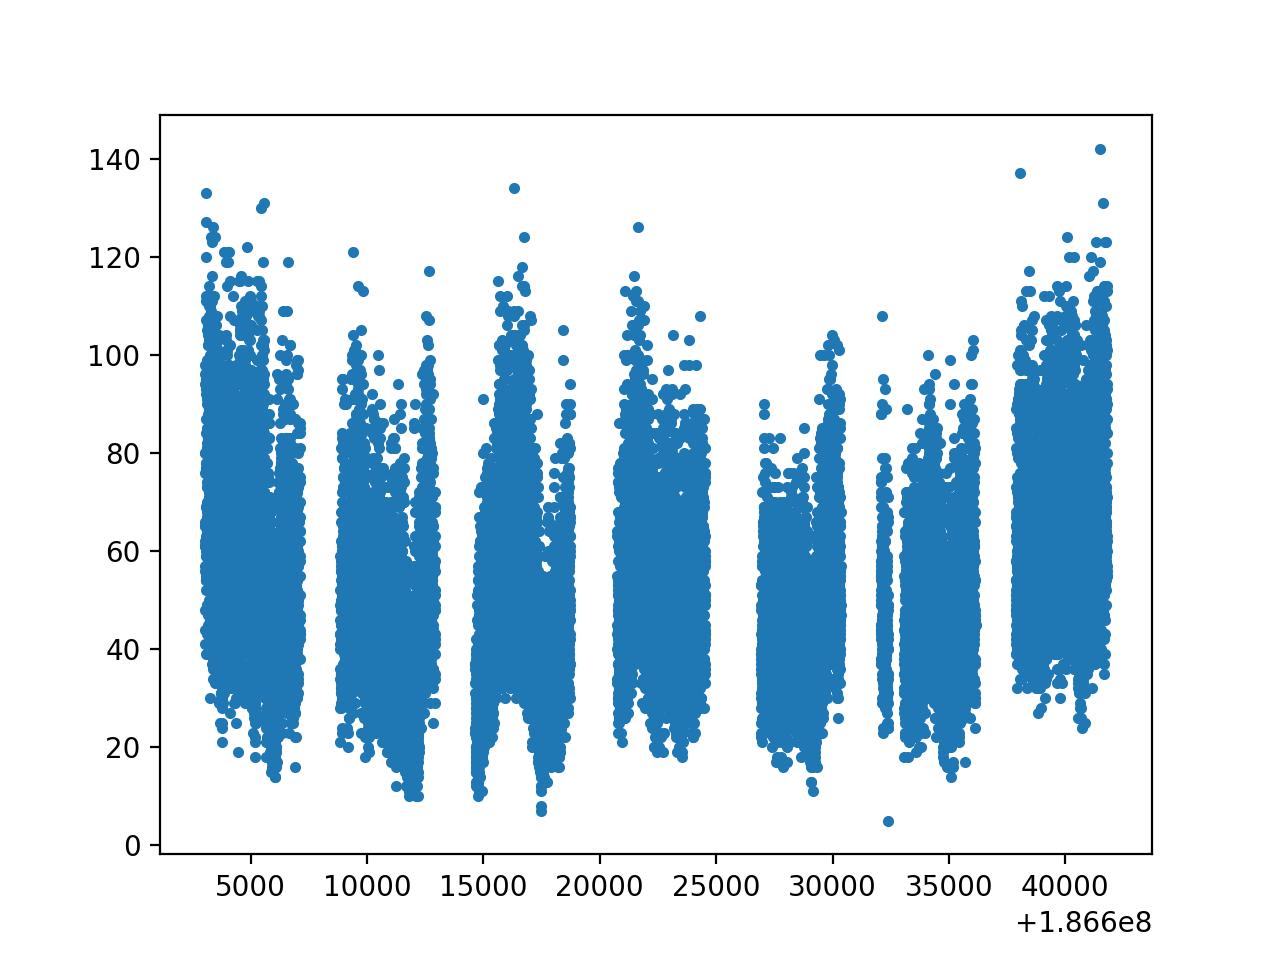

In [120]:
plt.figure()
plt.plot(lc.time, lc.counts, '.')

In [98]:
Event_file.data.shape

(1387011,)

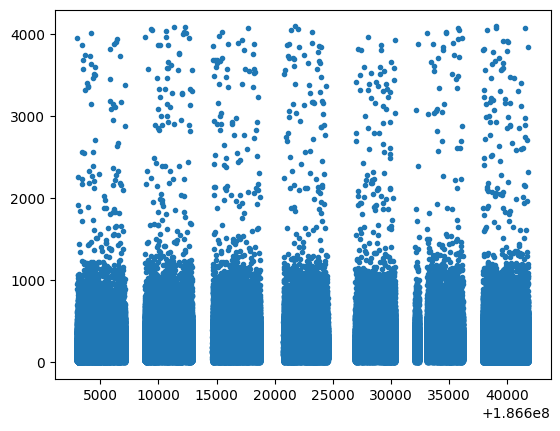

In [95]:
plt.plot(Event_file.data['TIME'], Event_file.data['PI'], '.')

### EX: Explain what it mean the barycentric correction: in which time system are the times in the events ?

The time system used for the timing of events is the number of seconds since a modified Julian date of reference.

### EX Visualize the light curve choosing a proper time binning and energy range. Light curve = event rate per unit time.
Suggestions, use one of:
- xselect (domain specific, available from the hesoft installation in the docker)
- lcurve (domain specific, available from the hesoft installation in the docker)
- stingray (https://iopscience.iop.org/article/10.3847/1538-4357/ab258d/meta python package in development)
- develop your own routine, 

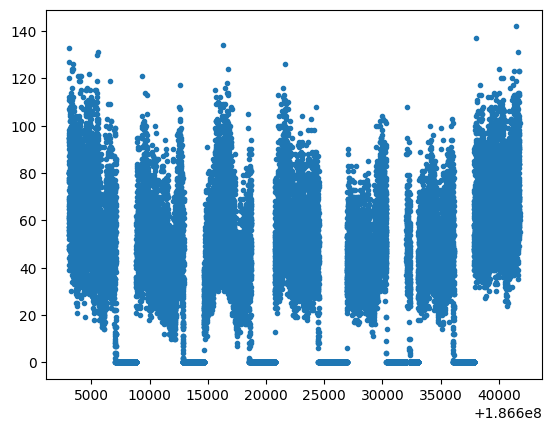

In [115]:
time = Event_file.data['TIME']
# Using stingray package to make time and count arrays 
tc = Lightcurve.make_lightcurve(time, dt=1, gti=gtis)
plt.plot(tc.time, tc.counts, '.')

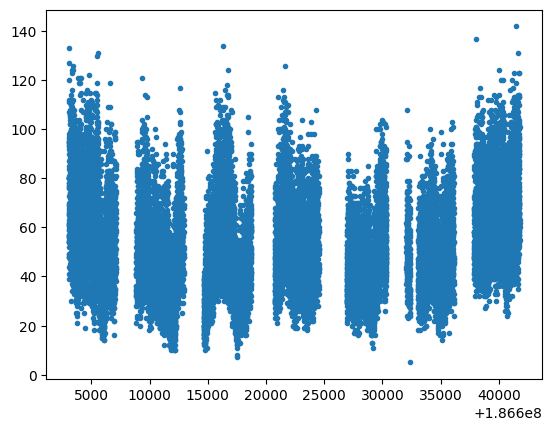

In [116]:
# Applying GTI to remove values going to zero 
tc.apply_gtis()
plt.plot(tc.time, tc.counts, '.')

3999


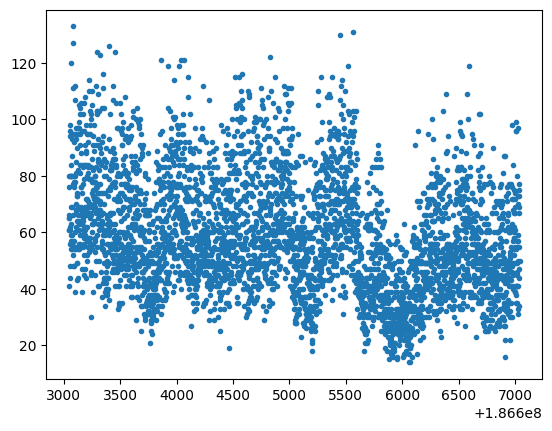

2
20
2
3943


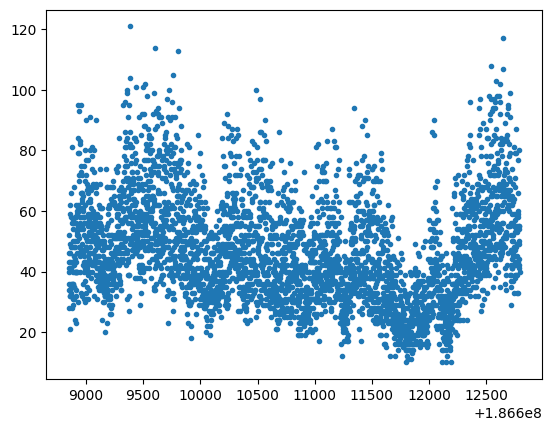

15
19
5
4
2
20
3907


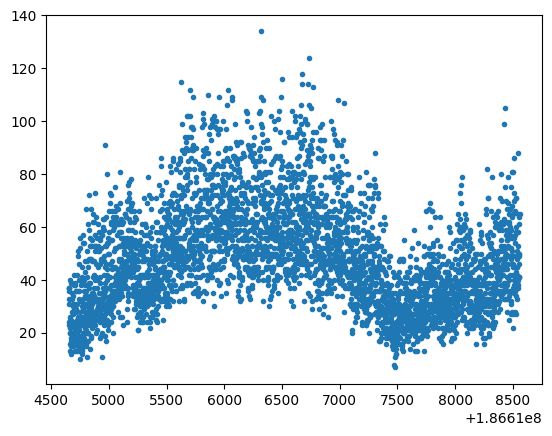

3
3
2
116
2
3670


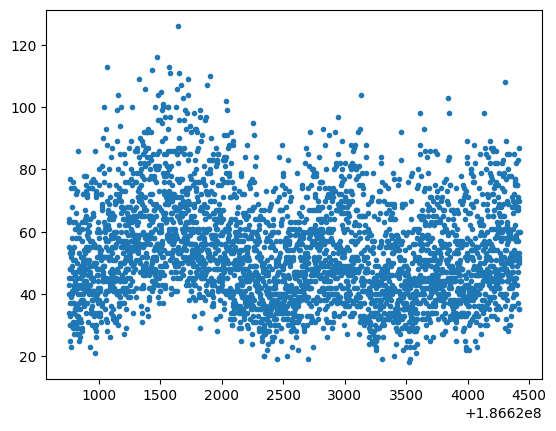

2
2
3
4
5
10
3
5
21
3398


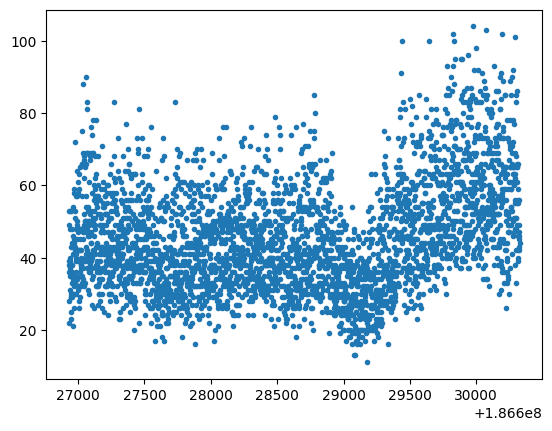

13
4
254


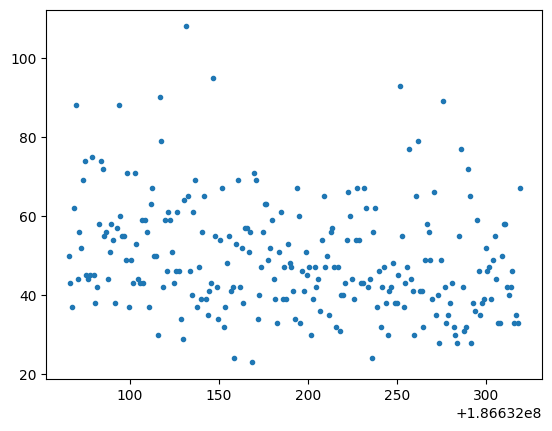

6
40
2999


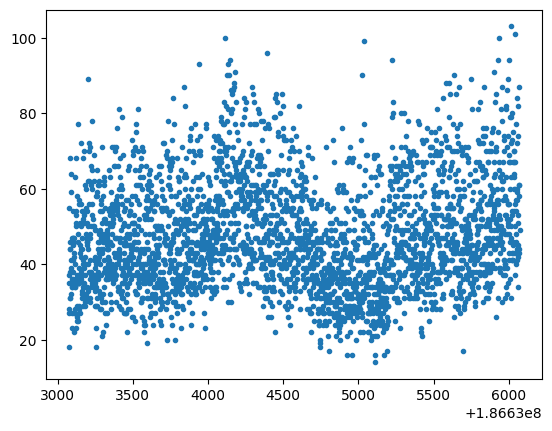

11
2
2
18
3917


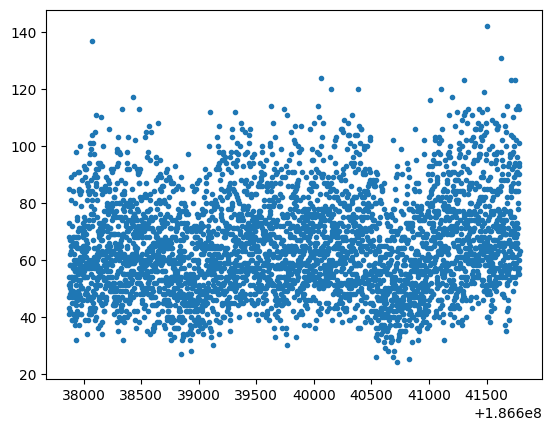

In [118]:
#Split lightcurve by GTIs
tc_split = tc.split_by_gti()
for i in tc_split:
    print(len(i))
    if len(i) > 200:
        plt.plot(i.time, i.counts, '.')
        plt.show()

### EX visualize an image of the three different event files
- suggestion xselect domain specific
- 2dhist in python (which columns to use?)
What is in these files?

### EX find the pulse period
- you should obtain a value like in https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/cenx3.html for the time of observation (please find it)
Suggestions: 
- make a power pectrum
- make a Lomb Scargle Periodogram
- make epoch folding

Compre results

### EX Make and plot a Time phase matrix
- Divide the observation in time intervals and for each time interval make a phase profile
- For each profile compute the phase of the main harmonic (fourier decomposition)
- Plot it as function of time
- What do you see ? (hint, frequency derivative ?)

### EX Orbital correction
- The neutron star is on a binary orbit, it is subject to Doppler shift
- It is necessary to compute the times on the lines of nodes of the system using Kepler's equation

(https://gitlab.astro.unige.ch/ferrigno/timingsuite/-/blob/master/src/binarycor.c) I do my own correction, maybe in stingray or other, there is something similar